In [1]:
import os 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
font = {'size': 16}

matplotlib.rc('font', **font)

In [4]:
import numpy as np
from typing import Tuple

# --------------------------------------------------------------------------------------------
def read_file(path: str):
    ''' Считывает значения из файла'''
    ar = []
    with open(path) as f:
        for line in f:
            ar.append(np.float64(line.strip()))    
    return np.array(ar)

# --------------------------------------------------------------------------------------------
def get_period(ar: np.array, T: int, start_point: int):
    ''' "Нарезает массив на периоды" '''
    m = np.copy(ar[start_point:])
    m.resize((m.shape[0] // T + 1, T), refcheck=False)
    return m[:-1]

# --------------------------------------------------------------------------------------------
def get_peak_range(ar: np.array, window: tuple):
    '''Вырезает окно в массиве'''
    return ar[window[0]:window[1]]

# --------------------------------------------------------------------------------------------
def find_min(ar: np.array, times: np.array, T: int, start_point: int, window: Tuple[int, int]):
    
    new_ar = get_period(ar, T, start_point)
    time_ar = get_period(times, T, start_point)
    time_period = time_ar[0, -1] - time_ar[0, 0]
    
    peak_shape = window[1] - window[0]
    peak_points = np.zeros((new_ar.shape[0], 2))
    middle = peak_shape // 2
        
    for num, period in enumerate(new_ar):
        
        peaks = get_peak_range(period, window)
        left_part, right_part = peaks[:middle], peaks[middle:]
        left_ind, right_ind = list(map(np.argmax, [left_part, right_part]))
        right_ind += middle
        curr_index = np.argmin(peaks[left_ind:right_ind]) 
        
        peak_points[num] = peaks[int(left_ind + curr_index)], time_ar[num, int(window[0] + left_ind + curr_index)]
        
    return peak_points

# --------------------------------------------------------------------------------------------
def save_peaks_to_txt(peaks: np.array, filename: str) -> None:
    '''Сохраняет результат в filename.
       Формат: значение пика\tвремя\n
    '''
    dirname = 'results'
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
        
    if not filename.endswith('.txt'):
        filename = f'{filename}.txt'
    
    save_path = os.path.join(dirname, filename)
    with open(save_path, 'w') as f:
        for point in peaks:
            f.write(f'{point[0]}\t{point[1]}\n')

# --------------------------------------------------------------------------------------------
def save_delta_to_txt(Delta: list, filename: str) -> None:
    dirname = 'results'
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    if not filename.endswith('.txt'):
        filename = f'{filename}.txt'
    
    save_path = os.path.join(dirname, filename)
    with open(save_path, 'w') as f:
        for item in Delta:
            f.write(f'{item}\n')

            
# --------------------------------------------------------------------------------------------
def allan_variance(peaks: np.array) -> float:
    res = np.sqrt(np.sum(np.diff(peaks)**2)) / 2 / (peaks.shape[0] - 1)
    return res


In [5]:
map_windows = {'1': (9100, (2100, 3100)),#(11000, 12100),
               '2': (8000, (2000, 3000)),
               '3': (5000, (2300, 3400)),
               '4': (3000, (2000, 2800))
              }

In [13]:
new_filename = lambda name: 'Результат {0}'.format(name.split('/')[-1][2:])
get_label = lambda name: str(name.split('/')[-1][2:-4])

#### Запуск для 35 периодов (только первый файл)

In [7]:
all_files = sorted([os.path.join(i[0], j) for num, i in enumerate(os.walk('data')) if num > 0 for j in i[-1]])
x = read_file('data/Координата X (время) экспериментального сигнала.txt')
path_to_files = all_files[::4]

In [36]:
# Период подобран
T = 13630
variance = np.zeros(6)
Delta = []
period = x[13630] - x[0]
for num, file in enumerate(path_to_files):
    ar = read_file(file)
    print(file)
    start_point, window = map_windows['1']
    
    peaks = find_min(ar, x, T, start_point, window)
    peaks = peaks.reshape(-1, 2)
    
    new_file = new_filename(file)
    save_peaks_to_txt(peaks, new_file)
    
    variance_n = np.array([allan_variance(peaks[:n, 0]) for n in range(2, peaks.shape[0])])
    xn_mean = np.array([np.mean(peaks[:n, 0]) for n in range(2, peaks.shape[0])])
    
    partial_variance = 100 * variance_n / xn_mean
    
    new_file = new_file.split()
    new_file.insert(1, 'дельта')
    new_file = ' '.join(new_file)
    save_delta_to_txt(partial_variance, new_file)
    Delta.append(partial_variance)


data/Добеши 10 FFT/1 Добеши 10 FFT.txt
data/Добеши 10/1 Добеши 10.txt
data/Коифлетс 5 FFT/1 Коифлетс 5 FFT.txt
data/Коифлетс 5/1 Коифлетс 5.txt
data/Симлет 8  FFT/1 Симлет 8 FFT.txt
data/Симлет 8/1 Симлет 8.txt


### общий график

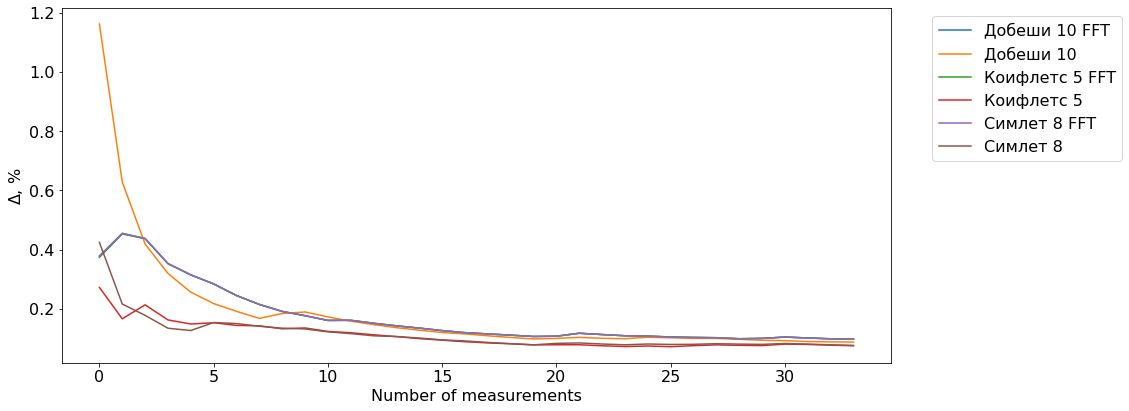

In [37]:
plt.figure(figsize=(16,6))
plt.ylabel('$\Delta$, %')
plt.xlabel('Number of measurements')
for delta, name in zip(Delta, path_to_files):
    plt.plot(delta, label=get_label(name))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('results/all_single_file.png', dpi=400)


### Без фурье по отдельности

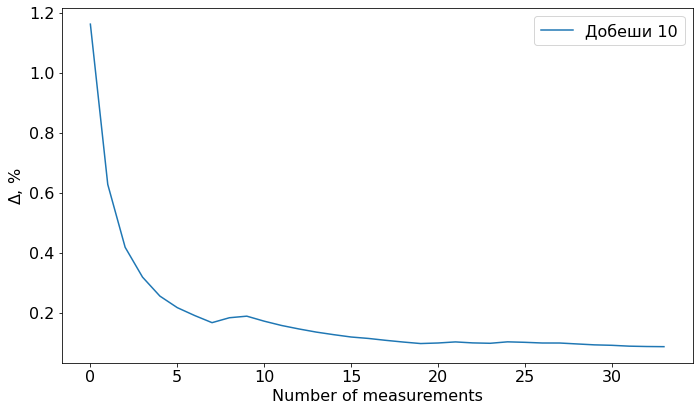

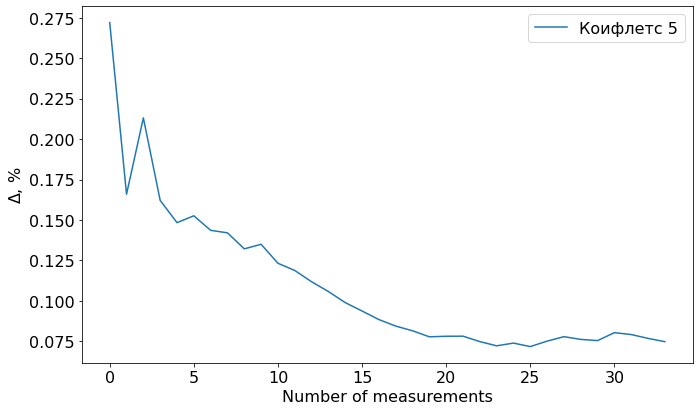

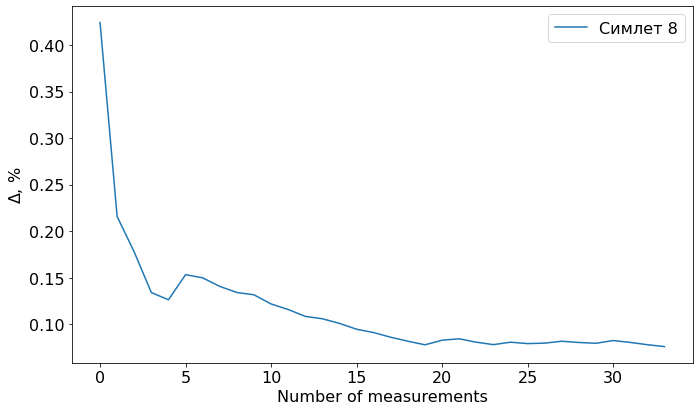

In [38]:
for delta, name in zip(Delta, path_to_files):
    if 'FFT' in get_label(name):
        continue
    plt.figure(figsize=(10,6))
    plt.ylabel('$\Delta$, %')
    plt.xlabel('Number of measurements')

    plt.plot(delta, label=get_label(name))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/{get_label(name)}35.png', dpi=400)

### FFT общий

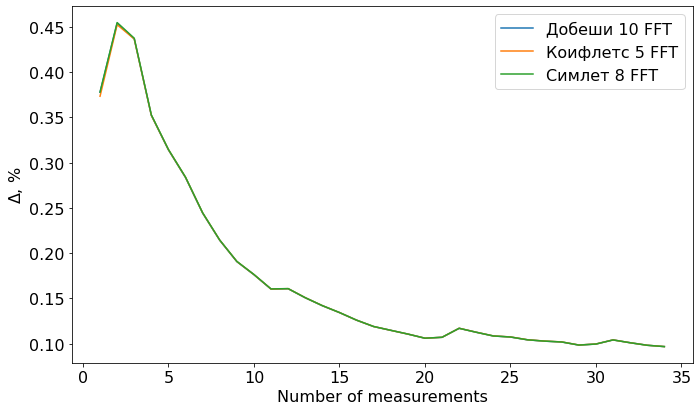

In [39]:
plt.figure(figsize=(10,6))
plt.ylabel('$\Delta$, %')
plt.xlabel('Number of measurements')
for delta, name in zip(Delta, path_to_files):
    if 'FFT' not in get_label(name):
        continue
    plt.plot(np.arange(1, len(delta)+1), delta, label=get_label(name))
plt.legend()
plt.tight_layout()
plt.savefig('results/FFT_all35.png', dpi=400)

#### Запуск для всех файлов

In [40]:
all_files = sorted([os.path.join(i[0], j) for num, i in enumerate(os.walk('data')) if num > 0 for j in i[-1]])
x = read_file('data/Координата X (время) экспериментального сигнала.txt')

In [41]:
path_to_files = [all_files[i: i+4] for i in range(0, len(all_files), 4)]

In [42]:
T = 13630
Delta = []
period = x[13630] - x[0]
for num, patch in enumerate(path_to_files):
    patch_peaks = np.array([])
    for num1, file in enumerate(patch, 1): 
        ar = read_file(file)
        print(file)
        start_point, window = map_windows[str(num1)]
    
        
        peaks = find_min(ar, x, T, start_point, window)
        patch_peaks = np.append(patch_peaks, peaks)
        
    patch_peaks = patch_peaks.reshape(-1, 2)
    new_file = new_filename(file)
    save_peaks_to_txt(patch_peaks, new_file)
    
    variance_n = np.array([allan_variance(patch_peaks[:n, 0]) for n in range(2, patch_peaks.shape[0])])
    xn_mean = np.array([np.mean(patch_peaks[:n, 0]) for n in range(2, patch_peaks.shape[0])])
    
    partial_variance = 100 * variance_n / xn_mean
    
    new_file = new_file.split()
    new_file.insert(1, 'дельта')
    new_file = ' '.join(new_file)
    save_delta_to_txt(partial_variance, new_file)
    
    Delta.append(partial_variance)


data/Добеши 10 FFT/1 Добеши 10 FFT.txt
data/Добеши 10 FFT/2 Добеши 10 FFT.txt
data/Добеши 10 FFT/3 Добеши 10 FFT.txt
data/Добеши 10 FFT/4 Добеши 10 FFT.txt
data/Добеши 10/1 Добеши 10.txt
data/Добеши 10/2 Добеши 10.txt
data/Добеши 10/3 Добеши 10.txt
data/Добеши 10/4 Добеши 10.txt
data/Коифлетс 5 FFT/1 Коифлетс 5 FFT.txt
data/Коифлетс 5 FFT/2 Коифлетс 5 FFT.txt
data/Коифлетс 5 FFT/3 Коифлетс 5 FFT.txt
data/Коифлетс 5 FFT/4 Коифлетс 5 FFT.txt
data/Коифлетс 5/1 Коифлетс 5.txt
data/Коифлетс 5/2 Коифлетс 5.txt
data/Коифлетс 5/3 Коифлетс 5.txt
data/Коифлетс 5/4 Коифлетс 5.txt
data/Симлет 8  FFT/1 Симлет 8 FFT.txt
data/Симлет 8  FFT/2 Симлет 8 FFT.txt
data/Симлет 8  FFT/3 Симлет 8 FFT.txt
data/Симлет 8  FFT/4 Симлет 8 FFT.txt
data/Симлет 8/1 Симлет 8.txt
data/Симлет 8/2 Симлет 8.txt
data/Симлет 8/3 Симлет 8.txt
data/Симлет 8/4 Симлет 8.txt


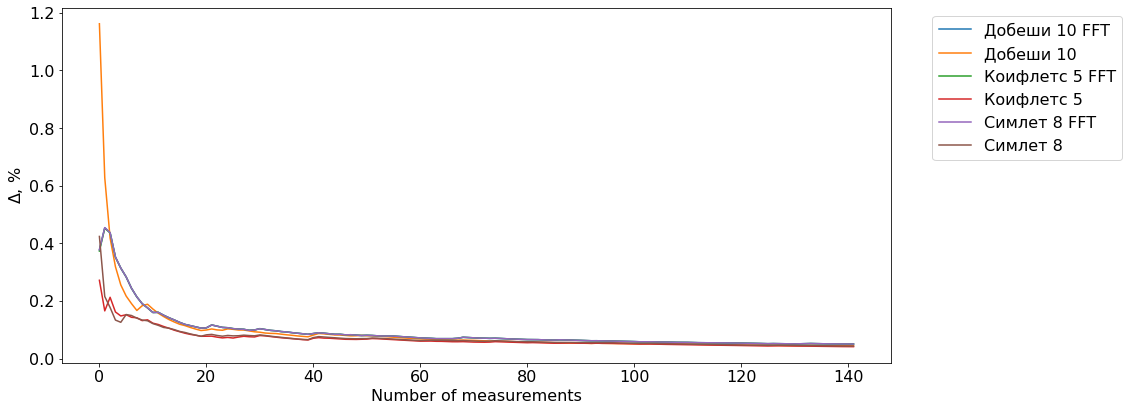

In [43]:
plt.figure(figsize=(16,6))
plt.ylabel('$\Delta$, %')
plt.xlabel('Number of measurements')
for delta, name in zip(Delta, path_to_files):
    plt.plot(delta, label=get_label(name[0]))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.savefig('results/all.png', dpi=400)


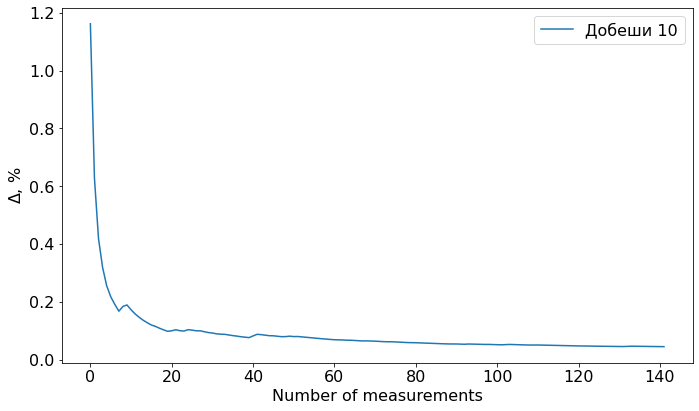

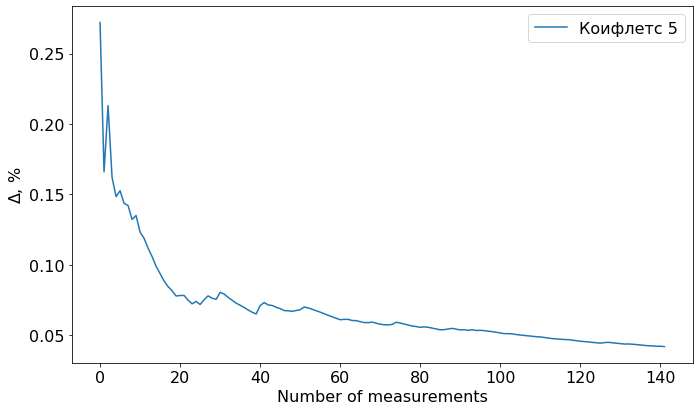

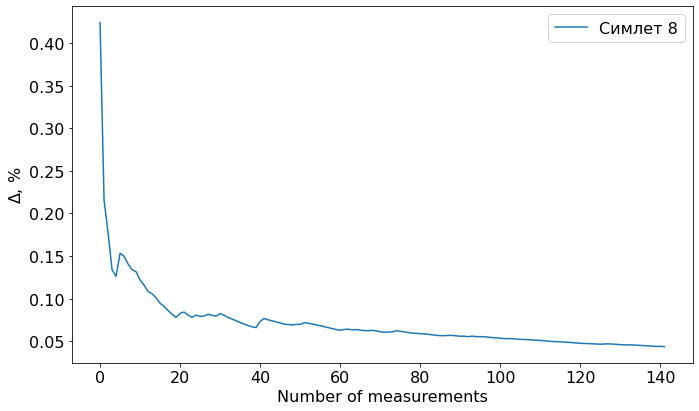

In [44]:
for delta, name in zip(Delta, path_to_files):
    if 'FFT' in get_label(name[0]):
        continue
    plt.figure(figsize=(10,6))
    plt.ylabel('$\Delta$, %')
    plt.xlabel('Number of measurements')

    plt.plot(delta, label=get_label(name[0]))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results/{get_label(name[0])}.png', dpi=400)

In [45]:
name

['data/Симлет 8/1 Симлет 8.txt',
 'data/Симлет 8/2 Симлет 8.txt',
 'data/Симлет 8/3 Симлет 8.txt',
 'data/Симлет 8/4 Симлет 8.txt']

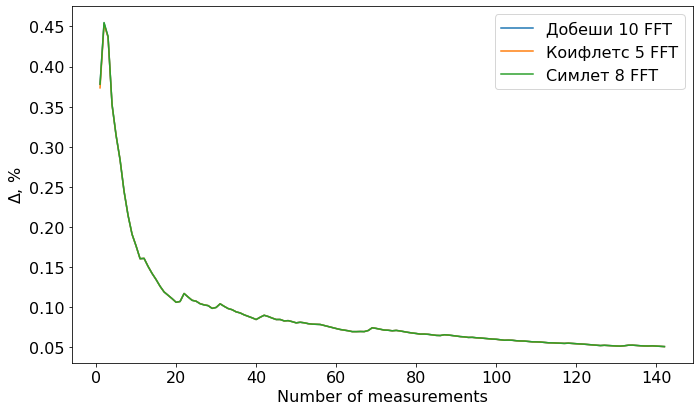

In [34]:
plt.figure(figsize=(10,6))
plt.ylabel('$\Delta$, %')
plt.xlabel('Number of measurements')
for delta, name in zip(Delta, path_to_files):
    if 'FFT' not in get_label(name[0]):
        continue
    plt.plot(np.arange(1, len(delta)+1), delta, label=get_label(name[0]))
plt.legend()
plt.tight_layout()
plt.savefig('results/FFT_all.png', dpi=400)